In [ ]:
! pip install python-dp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 70.6 MB/s eta 0:00:00


In [ ]:
! pip install pycanon

In [22]:
import pandas as pd
import numpy as np
from hashlib import sha256
from pydp.algorithms.laplacian import BoundedMean
from pycanon import anonymity, report

In [23]:
data = pd.read_csv('Employees.csv')
data.head()

,EmpID,FirstName,LastName,Title,Email,Password,EmployeeType,PayZone,DepartmentType,DOB,JobFunctionDescription,GenderCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating,monthly_salary
0,3427,Uriah,Bridges,Production Technician I,uriah.bridges@bilearner.com,uriahbridges3427,Contract,Zone C,Production,07-10-1969,Accounting,Female,White,Widowed,Fully Meets,4,6877
1,3428,Paula,Small,Production Technician I,paula.small@bilearner.com,paulasmall3428,Contract,Zone A,Production,30-08-1965,Labor,Male,Hispanic,Widowed,Fully Meets,3,5383
2,3429,Edward,Buck,Area Sales Manager,edward.buck@bilearner.com,edwardbuck3429,Full-Time,Zone B,Sales,06-10-1991,Assistant,Male,Hispanic,Widowed,Fully Meets,4,4722
3,3430,Michael,Riordan,Area Sales Manager,michael.riordan@bilearner.com,michaelriordan3430,Contract,Zone A,Sales,04-04-1998,Clerk,Male,Other,Single,Fully Meets,2,4779
4,3431,Jasmine,Onque,Area Sales Manager,jasmine.onque@bilearner.com,jasmineonque3431,Contract,Zone A,Sales,29-08-1969,Laborer,Female,Other,Married,Fully Meets,3,4638


In [24]:
# Borra LastName
data.drop('EmpID', axis=1, inplace=True)
data.drop('FirstName', axis=1, inplace=True)
data.drop('LastName', axis=1, inplace=True)
data.drop('JobFunctionDescription', axis=1, inplace=True)
data.drop('Title', axis=1, inplace=True)
data.drop('Password', axis=1, inplace=True)
data.drop('PayZone', axis=1, inplace=True)
data.drop('RaceDesc', axis=1, inplace=True)

In [25]:
# Enmascarar parte del correo manteniendo el dominio
data['Email'] = data['Email'].apply(lambda x: 'employee' + str(hash(x))[:5] + '@' + x.split('@')[-1])

In [26]:
performance_mapping = {
    'Fully Meets': 'Satisfactory',
    'Exceeds': 'Satisfactory',
    'Needs Improvement': 'Unsatisfactory',
    'PIP': 'Unsatisfactory'
}

marital_desc_mapping = {
    'Widowed': 'Not Married',
    'Single': 'Not Married',
    'Married': 'Married',
    'Divorced': 'Married'
}

data['Performance Score'] = data['Performance Score'].map(performance_mapping)
data['MaritalDesc'] = data['MaritalDesc'].map(marital_desc_mapping)

In [27]:
from datetime import datetime

# Convertir DOB a un formato datetime para calcular edad
data['DOB'] = pd.to_datetime(data['DOB'], format='%d-%m-%Y')
data['DOB'] = datetime.now().year - data['DOB'].dt.year

In [28]:
# Definir los rangos de edad
bins = [0, 24, 34, 44, 54, 64, 74, 100]
labels = ["<25", "25-34", "35-44", "45-54", "55-64", "65-74", "75+"]

# Crear una nueva columna con el rango de edad
data['DOB'] = pd.cut(data['DOB'], bins=bins, labels=labels, right=False)

In [29]:
# Renombra la columna DOB
data.rename(columns={'DOB': 'Age'}, inplace=True)
data.rename(columns={'FirstName': 'Name'}, inplace=True)

In [30]:
from pycanon import anonymity, report

QI = ["Performance Score", "Current Employee Rating"]
SA = ["monthly_salary"]

k = anonymity.k_anonymity(data, QI)

report.print_report(data, QI, SA)

The dataset verifies:
          	 - k-anonymity with k = 23
          	 - (alpha,k)-anonymity with alpha = 0.08695652173913043 and k = 23
          	 - l-diversity with l = 22
          	 - entropy l-diversity with l = 21
          	 - (c,l)-diversity with c = 1 and l = 22
          	 - basic beta-likeness with beta = 129.52173913043478
          	 - enhanced beta-likeness with beta = 8.007034012193408
          	 - t-closeness with t = 0.38726330308196083
          	 - delta-disclosure privacy with delta = 4.8715397962642575


In [31]:
from pydp.algorithms.laplacian import BoundedMean

lower_bound = data['monthly_salary'].min()
upper_bound = data['monthly_salary'].max()
epsilon = 35

def calculate_dp_average_salary(data, epsilon, lower, upper):
    dp_mean = BoundedMean(epsilon=epsilon, lower_bound=lower, upper_bound=upper)
    dp_mean.add_entries(data)
    return dp_mean.result()

dp_average_salary = calculate_dp_average_salary(data['monthly_salary'].values, epsilon, lower_bound, upper_bound)
data['dp_average_salary'] = dp_average_salary
print(f"Promedio de salario con privacidad diferencial: {dp_average_salary}")

Promedio de salario con privacidad diferencial: 4612.095602931379


In [34]:
data.head()

,Email,EmployeeType,DepartmentType,Age,GenderCode,MaritalDesc,Performance Score,Current Employee Rating,monthly_salary,dp_average_salary
0,employee14041@bilearner.com,Contract,Production,55-64,Female,Not Married,Satisfactory,4,6877,4612.095603
1,employee-6148@bilearner.com,Contract,Production,55-64,Male,Not Married,Satisfactory,3,5383,4612.095603
2,employee-5031@bilearner.com,Full-Time,Sales,25-34,Male,Not Married,Satisfactory,4,4722,4612.095603
3,employee-6266@bilearner.com,Contract,Sales,25-34,Male,Not Married,Satisfactory,2,4779,4612.095603
4,employee-3134@bilearner.com,Contract,Sales,55-64,Female,Married,Satisfactory,3,4638,4612.095603


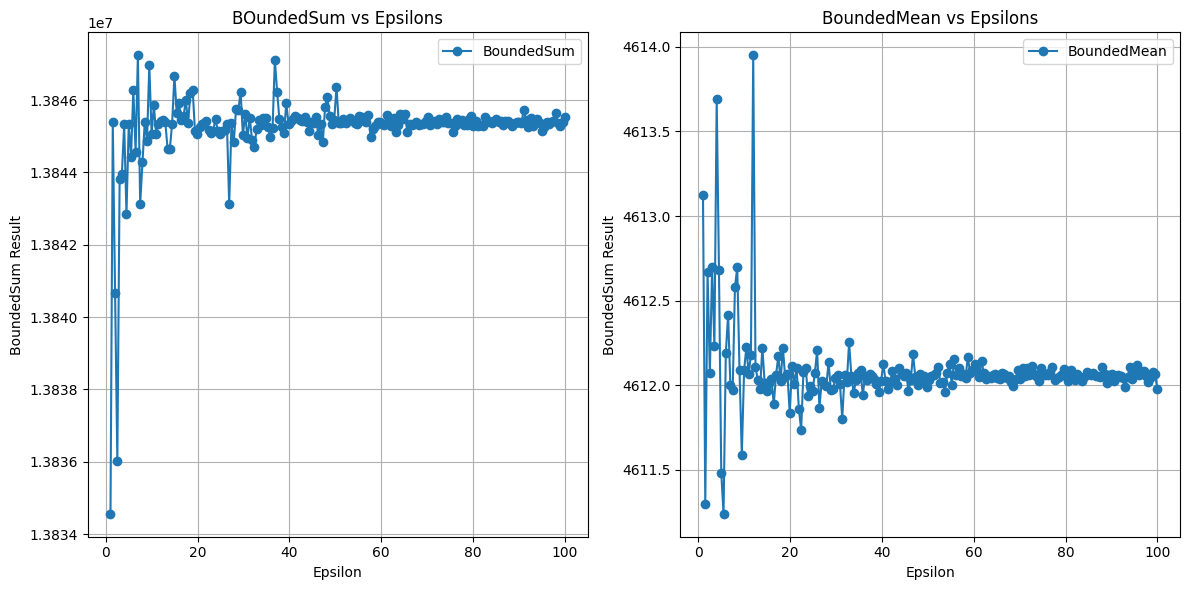

4612.056962025316


In [35]:
from pydp.algorithms.laplacian import BoundedSum
import matplotlib.pyplot as plt
import numpy as np
df = data['monthly_salary']

lower = data['monthly_salary'].min()
upper = data['monthly_salary'].max()
realSum = sum(df)
realMean = np.mean(df)

epsilons = np.linspace(1, 100, 200)

results_sum = []
results_mean = []

for eps in epsilons:
  bsum = BoundedSum(epsilon=eps,lower_bound = lower, upper_bound=upper )
  bsum.add_entries(df)
  results_sum.append(bsum.result())

  bmean = BoundedMean(epsilon=eps,lower_bound = lower, upper_bound=upper )
  bmean.add_entries(df)
  results_mean.append(bmean.result())

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epsilons, results_sum, marker="o", linestyle ='-', label="BoundedSum")
plt.title("BOundedSum vs Epsilons")
plt.xlabel("Epsilon")
plt.ylabel("BoundedSum Result")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epsilons, results_mean, marker="o", linestyle ='-', label="BoundedMean")
plt.title("BoundedMean vs Epsilons")
plt.xlabel("Epsilon")
plt.ylabel("BoundedSum Result")
plt.legend()
plt.grid(True)
plt.plot()

plt.tight_layout()
plt.show()
print(realMean)

In [36]:
# Guarda en un archivo csv data
data.to_csv('Employees_anonymized.csv', index=False)